# Rating Prediction Project

## Problem statement :
Rating prediction is a well-known recommendation task aiming to predict a user’s rating for those items which were not rated yet by her. Predictions are computed from users’ explicit feedback, i.e. their ratings provided on some items in the past. Another type of feedback are user reviews provided on items which implicitly express users’ opinions on items. Recent studies indicate that opinions inferred from users’ reviews on items are strong predictors of user’s implicit feedback or even ratings and thus, should be utilized in computation. As far as we know, all the recent works on recommendation techniques utilizing opinions inferred from users’ reviews are either focused on the item recommendation task or use only the opinion information, completely leaving users’ ratings out of consideration. The approach proposed in this paper is filling this gap, providing a simple, personalized and scalable rating prediction framework utilizing both ratings provided by users and opinions inferred from their reviews.
	
   Experimental results provided on dataset containing user ratings and reviews from the real-world Amazon and Flipkart Product Review Data show the effectiveness of the proposed framework.


## Importing Libraries

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#importing nltk libraries
import nltk
#nltk.download('all')
from nltk.corpus import stopwords
import re
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,precision_score, confusion_matrix, accuracy_score,classification_report

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
lemmatizer = nltk.stem.WordNetLemmatizer()

## Data Loading

In [4]:
#loading the data into a dataframe
df = pd.read_csv("Review_rating.csv")
df

,Unnamed: 0,Review_title,Reiew_text,Ratings
0,0,Suitable for School kids,\n If you are a College student or a professi...,2.0 out of 5 stars
1,1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2.0 out of 5 stars
2,2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2.0 out of 5 stars
3,3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2.0 out of 5 stars
4,4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2.0 out of 5 stars
...,...,...,...,...
77545,77545,Nice product,good product,4
77546,77546,Awesome,Very good as expected and happy with the purchase,5
77547,77547,Awesome,I love it! No complaint!,5
77548,77548,Nice product,good product,4


### Feature Information:
* Review_title : title of the review
* Review_text : content of the review text
* Ratings : ratings out of 5 stars

At first I will drop the unwanted column Unnamed: 0

In [5]:
df.drop(columns = 'Unnamed: 0',inplace = True)

In [6]:
#checking the shape
print("Shape :", df.shape)

Shape : (77550, 3)


Great our data set is having 77550 rows and three columns now 

In [7]:
#checking column names
print("Columns :", df.columns)

Columns : Index(['Review_title', 'Reiew_text', 'Ratings'], dtype='object')


In [8]:
#data types
df.dtypes

Review_title    object
Reiew_text      object
Ratings         object
dtype: object

In [9]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77550 entries, 0 to 77549
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Review_title  68521 non-null  object
 1   Reiew_text    69465 non-null  object
 2   Ratings       68523 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


By checking all above observations we can say the data contains three columns Review_title , Reiew_text and Ratings. All columns are object type.
Here Ratings column is our target column.

### Check for missing values

In [10]:
#missing values
df.isnull().sum()

Review_title    9029
Reiew_text      8085
Ratings         9027
dtype: int64

The data set is having lot of missing values and we will drop these values.

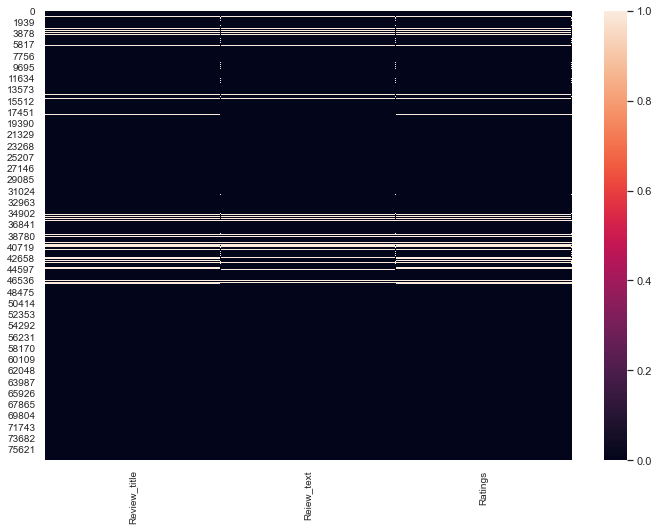

In [11]:
#Visualization of missing values
sns.set(rc={'figure.figsize':(11.8,8.27)})
sns.heatmap(data=df.isnull())
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [12]:
#Drop the rows where review_title and Reiew_text has null values
df.dropna(subset=['Review_title','Reiew_text'], inplace=True)

In [13]:
#checking for null values again
df.isnull().sum()

Review_title    0
Reiew_text      0
Ratings         0
dtype: int64

Great we have successfully removed all the missing data from our data set.

In [14]:
#lets check the shape of our data set now
df.shape

(68294, 3)

### Lets have a look at our target column

In [15]:
df['Ratings'].unique()

array(['2.0 out of 5 stars', '3.0 out of 5 stars', '1.0 out of 5 stars',
       '5.0 out of 5 stars', '4.0 out of 5 stars', '5', '1', '4', '3',
       '2'], dtype=object)

Looking at these entries in target column we came to know that we need to replace the string entries to respective values(stars)

In [16]:
df['Ratings'] = df['Ratings'].replace('1.0 out of 5 stars',1)
df['Ratings'] = df['Ratings'].replace('2.0 out of 5 stars',2)
df['Ratings'] = df['Ratings'].replace('3.0 out of 5 stars',3)
df['Ratings'] = df['Ratings'].replace('4.0 out of 5 stars',4)
df['Ratings'] = df['Ratings'].replace('5.0 out of 5 stars',5)
df['Ratings'] = df['Ratings'].astype('int')

In [17]:
df['Ratings'].unique()

array([2, 3, 1, 5, 4])

## Combine Review_title and Reiew_text into one

In [18]:
#joining Review text and title
df['Review'] = df['Review_title'].map(str)+' '+df['Reiew_text']

In [19]:
#lets have a look at our data now
df

,Review_title,Reiew_text,Ratings,Review
0,Suitable for School kids,\n If you are a College student or a professi...,2,Suitable for School kids \n If you are a Coll...
1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2,Misrepresentation on MS Office 2019 license - ...
2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2,The sold me renewed laptop \n It’s look like ...
3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2,Amazon dupes with specification/ battery sucks...
4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2,Display back light issue \n Display gone with...
...,...,...,...,...
77545,Nice product,good product,4,Nice product good product
77546,Awesome,Very good as expected and happy with the purchase,5,Awesome Very good as expected and happy with t...
77547,Awesome,I love it! No complaint!,5,Awesome I love it! No complaint!
77548,Nice product,good product,4,Nice product good product


### Visualizing text in first three rows from Review column

In [20]:
df['Review'][0]

'Suitable for School kids \n  If you are a College student or a professional who depends heavily on laptop for pretty much everyday then  this laptop is not for you. It hangs more often than it runs. Cannot install essential computer science software such as Eclipse or android studio because then this laptop just dies.<br><br>I took this laptop thinking that it will have good performance based on its configuration.<br><br>But if you are someone who wants to attend online classes or just browse, then you may go for this laptop.\n'

In [21]:
df['Review'][1]

'Misrepresentation on MS Office 2019 license - it is one month trial \n  Update after one month usage - MS Office 2019 preinstalled edition became unlicensed version within 30 days and refused to activate. HP support shared their product sheet that stated that this laptop came only with a trial version of MS Office 2019. Now I am chasing seller Appario Retail to honour the commitment.<br><br>Bad experience after paying high price (around ₹67,000) for preinstalled genuine software.<br><br>Other wise product has sleek looks, superfast fingerprint scanner, very good display, very responsive touchpad, decent (but tinny) speakers, USB C and barrel plug charging options and under 10 second boot up (SSD drive). Preloaded with Win10 Home and MS Office (not sure whether trial or full version). Drawbacks - weighs 1.42 kg, base gets warm rather quickly and so does the power adapter. Decent for a college student.\n'

In [22]:
df['Review'][2]

'The sold me renewed laptop \n  It’s look like renewed laptop because laptop charging jack is loose and left side speaker sounds like it’s tear. Bad sound quality  and finger sensor quality look like 2011 touch phone of wing and any Chinese phone touch. Waste of money and one more thing day by day Amazon product quality getting poor\n'

## Text Processing

In [23]:
#Here I am defining a function to replace some of the contracted words to their full form and removing urls and some unwanted text 
def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

In [24]:
#Lowercasing
df['Review'] = df['Review'].apply(lambda x : x.lower())

df['Review'] = df['Review'].apply(lambda x : decontracted(x))

#removing punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]','')
df['Review'] = df['Review'].str.replace('\n',' ')


### lets have a look at our text again

In [25]:
df['Review'][0]

'suitable for school kids    if you are a college student or a professional who depends heavily on laptop for pretty much everyday then  this laptop is not for you it hangs more often than it runs cannot install essential computer science software such as eclipse or android studio because then this laptop just dies  i took this laptop thinking that it will have good performance based on its configuration  but if you are someone who wants to attend online classes or just browse then you may go for this laptop '

In [26]:
df['Review'][1]

'misrepresentation on ms office 2019 license  it is one month trial    update after one month usage  ms office 2019 preinstalled edition became unlicensed version within 30 days and refused to activate hp support shared their product sheet that stated that this laptop came only with a trial version of ms office 2019 now i am chasing seller appario retail to honour the commitment  bad experience after paying high price around 67000 for preinstalled genuine software  other wise product has sleek looks superfast fingerprint scanner very good display very responsive touchpad decent but tinny speakers usb c and barrel plug charging options and under 10 second boot up ssd drive preloaded with win10 home and ms office not sure whether trial or full version drawbacks  weighs 142 kg base gets warm rather quickly and so does the power adapter decent for a college student '

Great; we can clearly observe that we have successfully removed punctuations and unwanted text from our text and lowercased all our text

In [29]:
#Remove stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [30]:
df['Review'][0]

'suitable school kids college student professional depends heavily laptop pretty much everyday laptop hangs often runs cannot install essential computer science software eclipse android studio laptop dies took laptop thinking good performance based configuration someone wants attend online classes browse may go laptop'

In [31]:
df['Review'][1]

'misrepresentation ms office 2019 license one month trial update one month usage ms office 2019 preinstalled edition became unlicensed version within 30 days refused activate hp support shared product sheet stated laptop came trial version ms office 2019 chasing seller appario retail honour commitment bad experience paying high price around 67000 preinstalled genuine software wise product sleek looks superfast fingerprint scanner good display responsive touchpad decent tinny speakers usb c barrel plug charging options 10 second boot ssd drive preloaded win10 home ms office sure whether trial full version drawbacks weighs 142 kg base gets warm rather quickly power adapter decent college student'

We can see that now we are having text without any stop words in it.

### Lemmatization

In [32]:
#Defining functiom to convert nltk tag to wordnet tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [33]:
#defining function to lemmatize our text
def lemmatize_sentence(sentence):
    #tokenize the sentence & find the pos tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatize_sentence)

In [34]:
df['Review'] = df['Review'].apply(lambda x : lemmatize_sentence(x))

In [35]:
df['Review'][0]

'suitable school kid college student professional depend heavily laptop pretty much everyday laptop hang often run can not install essential computer science software eclipse android studio laptop dy take laptop thinking good performance base configuration someone want attend online class browse may go laptop'

In [36]:
df['Review'][1]

'misrepresentation m office 2019 license one month trial update one month usage m office 2019 preinstalled edition become unlicensed version within 30 day refuse activate hp support share product sheet state laptop come trial version m office 2019 chase seller appario retail honour commitment bad experience pay high price around 67000 preinstalled genuine software wise product sleek look superfast fingerprint scanner good display responsive touchpad decent tinny speaker usb c barrel plug charge option 10 second boot ssd drive preloaded win10 home m office sure whether trial full version drawback weigh 142 kg base get warm rather quickly power adapter decent college student'

### Text Normalization - Standardization

In [37]:
#Noice removal
def scrub_words(text):
    #remove html markup
    text = re.sub("(<.*?>)", "", text)
    #remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    #remove white space
    text = text.strip()
    return text

In [38]:
df['Review'] = df['Review'].apply(lambda x : scrub_words(x))

In [39]:
df['Review'][0]

'suitable school kid college student professional depend heavily laptop pretty much everyday laptop hang often run can not install essential computer science software eclipse android studio laptop dy take laptop thinking good performance base configuration someone want attend online class browse may go laptop'

In [40]:
df['Review'][1]

'misrepresentation m office  license one month trial update one month usage m office  preinstalled edition become unlicensed version within  day refuse activate hp support share product sheet state laptop come trial version m office  chase seller appario retail honour commitment bad experience pay high price around  preinstalled genuine software wise product sleek look superfast fingerprint scanner good display responsive touchpad decent tinny speaker usb c barrel plug charge option  second boot ssd drive preloaded win home m office sure whether trial full version drawback weigh  kg base get warm rather quickly power adapter decent college student'

Finally I have defined a function scrub_words for removing the noise from the text. It will remove any html markups, digits and white spaces from the text. We can understand it by looking at first two row's text from review column

Now We have did all the text-processing steps and got required input for our model. We will go for EDA now

## Exploratory Data Analysis

### Word Counts

In [41]:
#creating column for word counts in the text
df['Review_WC'] = df['Review'].apply(lambda x: len(str(x).split(' ')))
df[['Review_WC','Review']].head()

,Review_WC,Review
0,44,suitable school kid college student profession...
1,103,misrepresentation m office license one month ...
2,43,sell renew laptop look like renew laptop lapto...
3,21,amazon dupe specification battery suck nbspi s...
4,16,display back light issue display go month any...


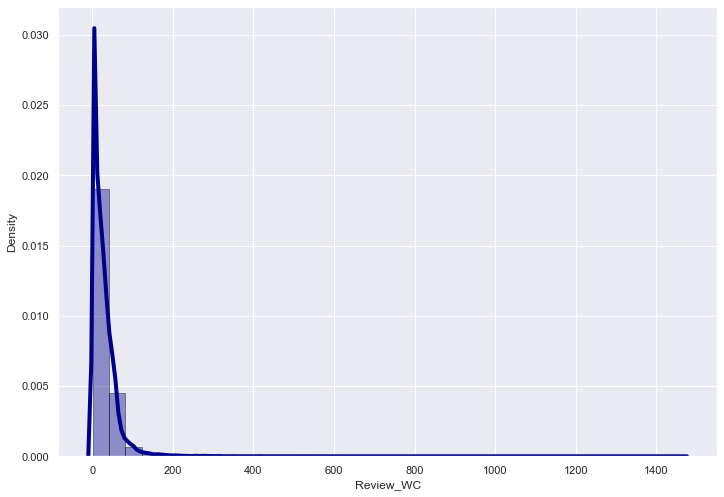

In [42]:
#density plot and histogram of all word count
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

Looking at the above histogram we can clearly observe that most of our text is having the number of words in the range of 0 to 200, But some of the reviews are too lengthy which may act like outliers in our data. 

### Character count

In [43]:
#creating column for character counts in the text
df['Review_CC'] = df['Review'].str.len()
df[['Review_CC','Review']].head()

,Review_CC,Review
0,309,suitable school kid college student profession...
1,654,misrepresentation m office license one month ...
2,250,sell renew laptop look like renew laptop lapto...
3,126,amazon dupe specification battery suck nbspi s...
4,102,display back light issue display go month any...


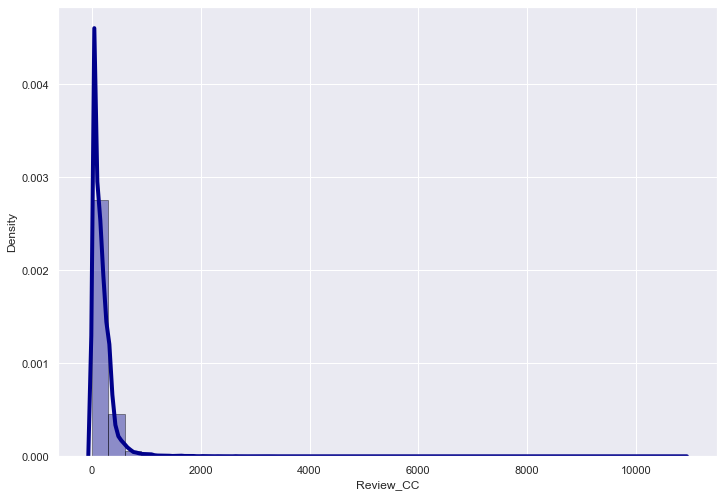

In [44]:
#density plot and histogram of all character count
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

Above plot represents histogram for character count of review text, which is quite similar to the histogram of word count.

### Removing Outliers

As we know that some of the review are too lengthy I am removing those reviews from the dats as outliers using z_score method.

In [45]:
#apply zscore to remove outliers
from scipy import stats
from scipy.stats import zscore
z_score = zscore(df[['Review_WC']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.shape

(67260, 6)

Great, by removing outliers we are loosing only arround 1000 entries which is acceptable here for getting beter results for our model.

### Plotting histograms for word count and character counts again after removing outliers

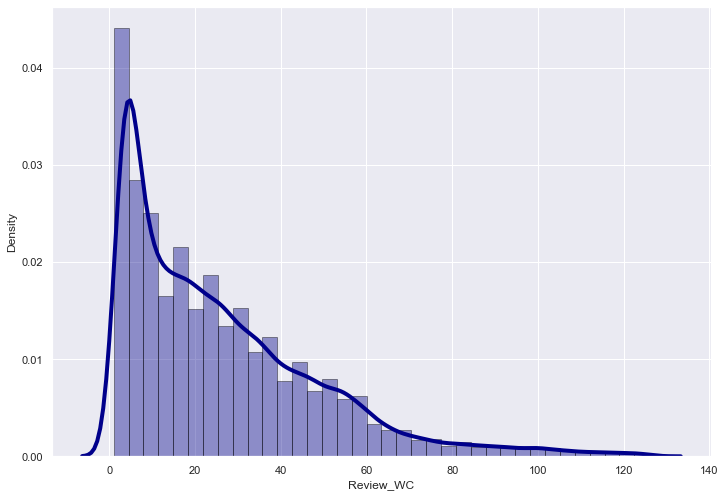

In [46]:
#density plot and histogram of all word count
sns.distplot(df['Review_WC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

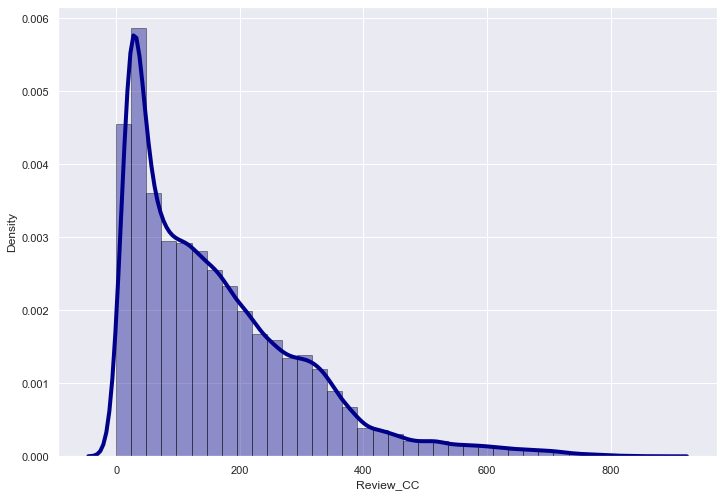

In [47]:
#density plot and histogram of all word count
sns.distplot(df['Review_CC'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'black'},
            kde_kws = {'linewidth':4})
plt.show()

After plotting histograms for word counts and character counts after removing outliers we can see now we are with good range of number of words and characters

In [48]:
#lets have a look at our data set
df

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,Suitable for School kids,\n If you are a College student or a professi...,2,suitable school kid college student profession...,44,309
1,Misrepresentation on MS Office 2019 license - ...,\n Update after one month usage - MS Office 2...,2,misrepresentation m office license one month ...,103,654
2,The sold me renewed laptop,\n It’s look like renewed laptop because lapt...,2,sell renew laptop look like renew laptop lapto...,43,250
3,Amazon dupes with specification/ battery sucks,\n &nbsp;I had seen the specifications and bo...,2,amazon dupe specification battery suck nbspi s...,21,126
4,Display back light issue,\n Display gone with 2 months.. But anyway th...,2,display back light issue display go month any...,16,102
...,...,...,...,...,...,...
77545,Nice product,good product,4,nice product good product,4,25
77546,Awesome,Very good as expected and happy with the purchase,5,awesome good expect happy purchase,5,34
77547,Awesome,I love it! No complaint!,5,awesome love complaint,3,22
77548,Nice product,good product,4,nice product good product,4,25


5    26839
4    13710
1    10316
3     9039
2     7356
Name: Ratings, dtype: int64


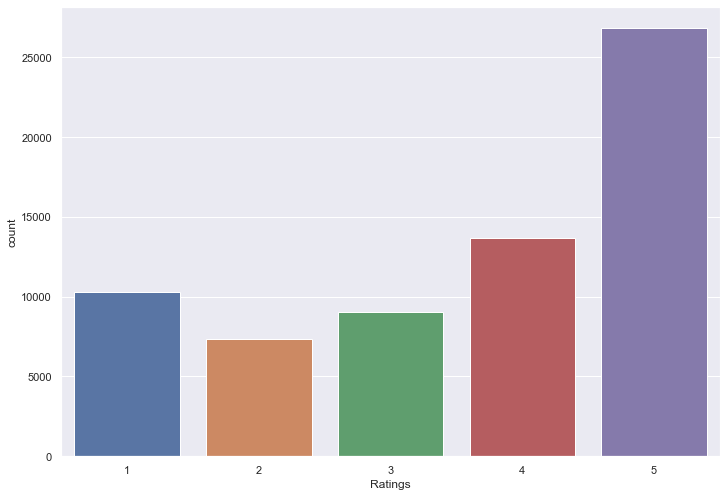

In [49]:
#Check the count of target column
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

* Looking at the above count plot for our target varible(Ratings) we can say that the data set is having most number of reviews rated as 5 star. and very less number of reviews rated as 2.
* Which will cause the __Imbalance problem__ for our model.
* So I am selecting equal number of reviews of each rating as a input for our model
* For that first I will shuffle the dataset so that we can select data from both web-sites
* Then I will select equal number of data of every category

In [50]:
#shuffling the data set
df = df.sample(frac=1).reset_index(drop=True)

In [51]:
df

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,"A budget headphones with good sound quality, p...","\n Product was a budget one, sturdy for peopl...",4,budget headphone good sound quality pretty oka...,64,438
1,Produces more radiation- worst production,\n Promised features are available but it is ...,1,produce radiation bad production promise featu...,24,166
2,The price-point champion.!!,\n It goes without saying that this product i...,4,pricepoint champion go without say product pro...,118,758
3,Quality gaming headset,"\n Impressive big cup size, bass quality, it ...",5,quality game headset impressive big cup size b...,41,284
4,Mind-blowing purchase,Best,5,mindblowing purchase best,3,25
...,...,...,...,...,...,...
67255,Super watch,"\n I got it for 2250rs, with is price range g...",5,super watch get rs price range good watch look...,27,145
67256,Very Good,It was a Xmas gift for my fiance. And she love...,4,good xmas gift fiance love good battery back p...,18,103
67257,Nagateb display,Spekars nahe,5,nagateb display spekars nahe,4,28
67258,Worth the money,"Buy it nothing to say except , 512gb SSD isn't...",4,worth money buy nothing say except gb ssd gon ...,30,155


In [52]:
#selct data from every category
df1 = df[df['Ratings']==1][0:7356]
df2 = df[df['Ratings']==2][0:7356]
df3 = df[df['Ratings']==3][0:7356]
df4 = df[df['Ratings']==4][0:7356]
df5 = df[df['Ratings']==5][0:7356]

In [53]:
#Combining all the dataframes into one and shuffling them 
df = pd.concat([df1,df2,df3,df4,df5],ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df

,Review_title,Reiew_text,Ratings,Review,Review_WC,Review_CC
0,"Phone is not good,go for some other phone.",\n Not a good phone.\n,2,phone goodgo phone good phone,5,29
1,Good quality product,Monitor is great on its own but it wasn't a wo...,4,good quality product monitor great worthy upgr...,46,301
2,Not compatible with the source,\n Gets disconnected with the source quite of...,2,compatible source get disconnect source quite ...,13,87
3,Good,"\n I brought this watch at price of 2500, onl...",4,good bring watch price two issue find sometim...,31,200
4,Good router but JIO SIMdid not work,\n Hello I purchased this router only for Dat...,3,good router jio simdid work hello purchase rou...,48,257
...,...,...,...,...,...,...
36775,Good choice,Good monitor,4,good choice good monitor,4,24
36776,Not good,Writing this review after a month of use.\nCon...,2,good write review month use con battery would...,39,188
36777,Awesome piece,\n Nice mobile\n,5,awesome piece nice mobile,4,25
36778,Build quality is the worse,\n Headphones are quite impressive but the bu...,2,build quality bad headphone quite impressive b...,40,272


1    7356
2    7356
3    7356
4    7356
5    7356
Name: Ratings, dtype: int64


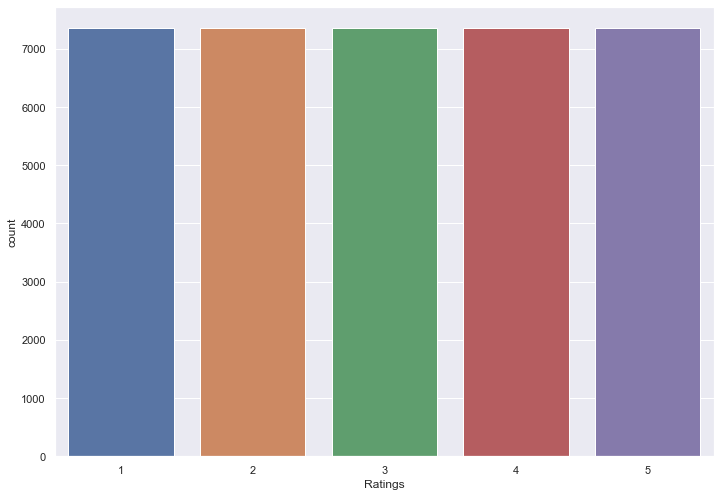

In [54]:
#lets Check the count of target column again
sns.countplot(df['Ratings'])
print(df.Ratings.value_counts())
plt.show()

great, we have balanced our data.

### Top 30 most frequently occuring words

In [55]:
#function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nlargest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

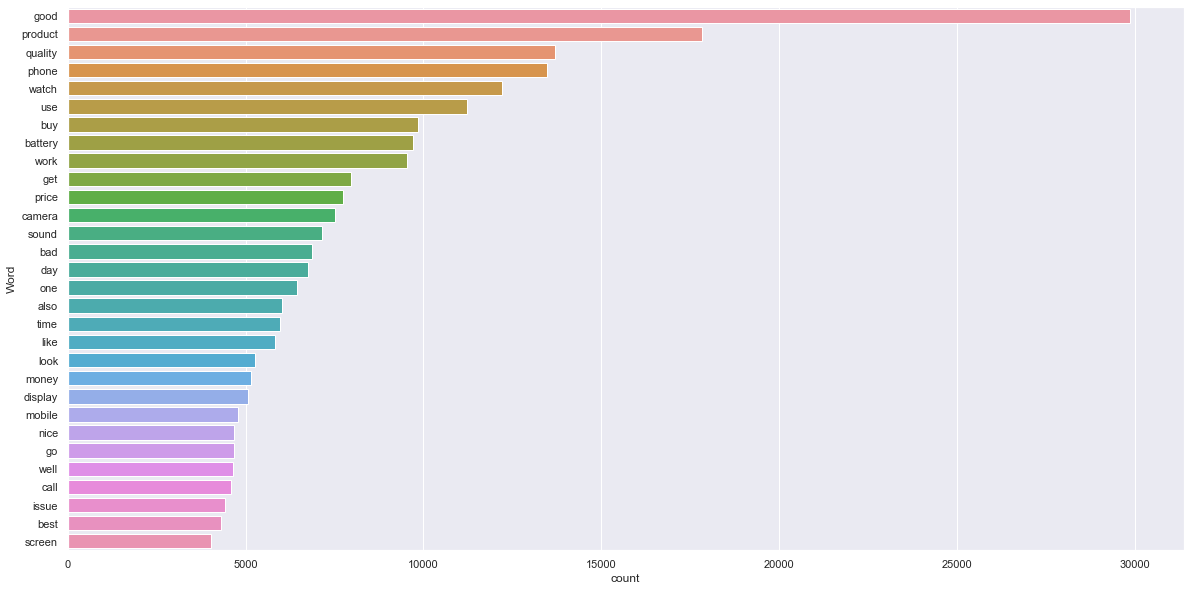

In [56]:
freq_words(df['Review'])

### Top 30 Rare words

In [57]:
#function to plot least frequent terms
def rare_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nsmallest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()

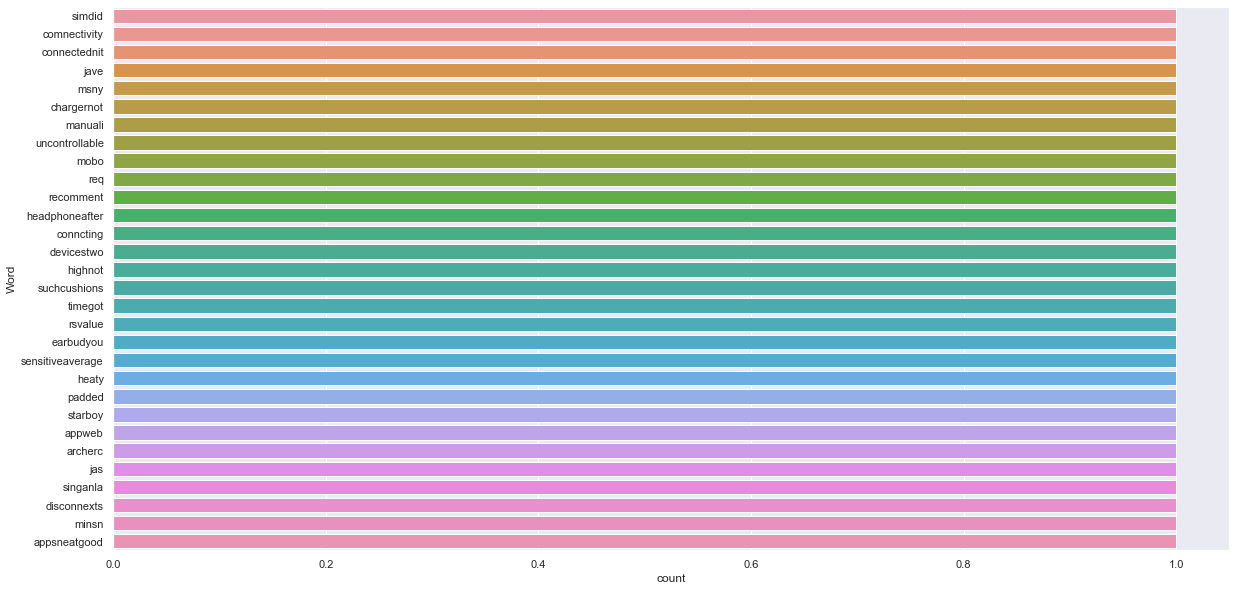

In [58]:
rare_words(df['Review'])

In [60]:
!pip install wordcloud

### Word cloud

In [61]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stopwords,
                    max_words = 500,
                    max_font_size = 40,
                    scale = 3,
                    random_state = 1).generate(str(data))
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

### Words for rating = 1:

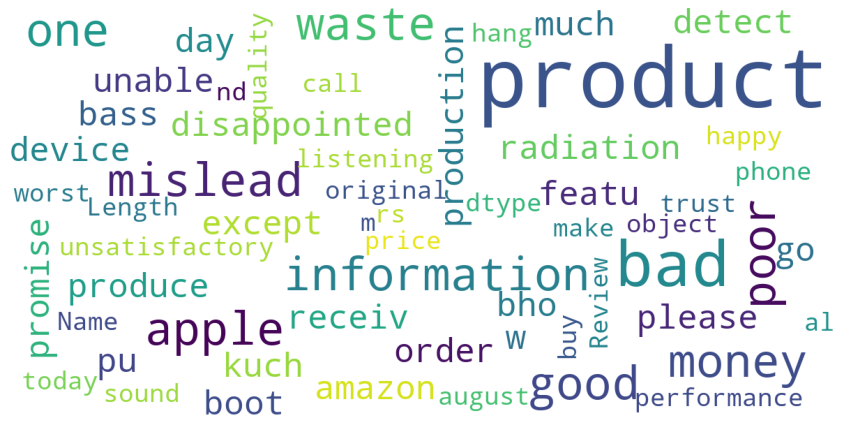

In [62]:
show_wordcloud(df1['Review'])

### Words for rating = 2:

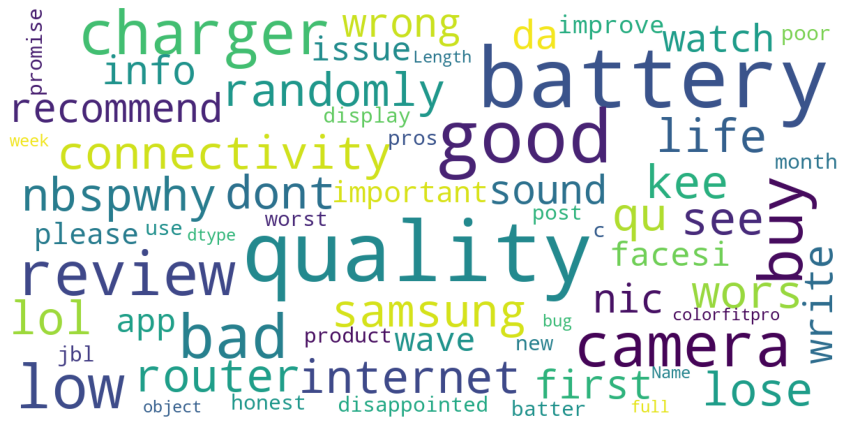

In [63]:
show_wordcloud(df2['Review'])

### Words for rating = 3:

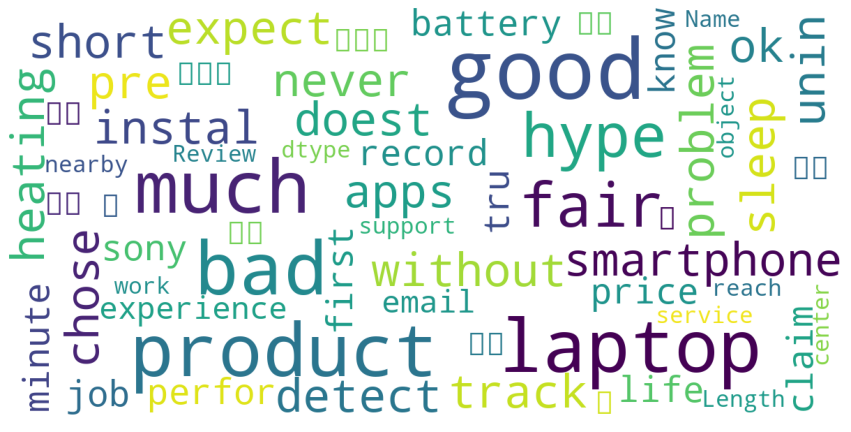

In [64]:
show_wordcloud(df3['Review'])

### Words for rating = 4:

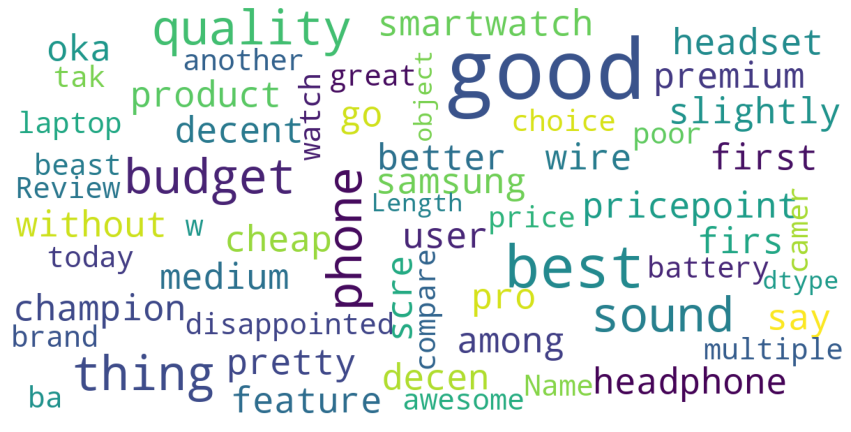

In [65]:
show_wordcloud(df4['Review'])

### Words for rating = 5:

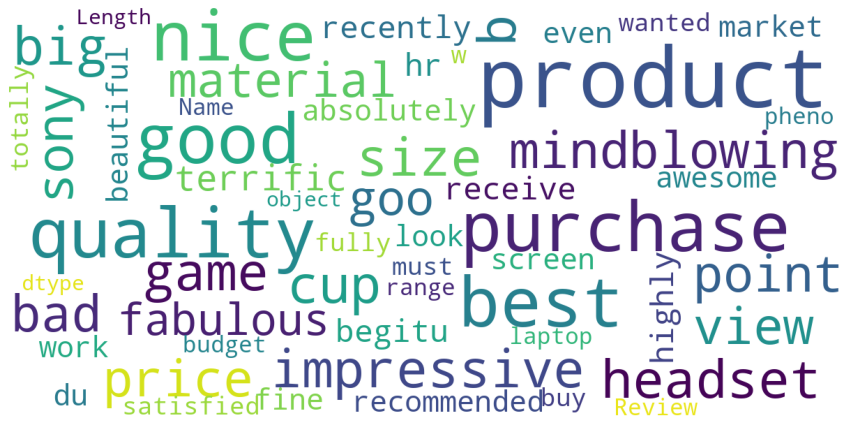

In [66]:
show_wordcloud(df5['Review'])

## Model Building and Evaluation

In [67]:
#separating features and labels
x = df['Review']
y = df['Ratings']

### Converting text into vectors using TfidfVectorizer

In [68]:
#using the n_gram tfidf vectorizer(Word vectors)
word_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'word',
                                token_pattern = r'\w{1,}',
                                stop_words = 'english',
                                ngram_range = (1,3),
                                max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

In [69]:
#Character vectors
char_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'char',
                                stop_words = 'english',
                                ngram_range = (2,6),
                                max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

In [70]:
#I will combine both word vectors and character vectors as input for our model
train_features = hstack([train_char_features,train_word_features])

### Splitting the data into train and test

In [71]:
seed = 1
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.25, random_state = seed)

In [72]:
#lets check the shapes of traning and test data
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

x_train (27585, 150000)
x_test (9195, 150000)
y_train (27585,)
y_test (9195,)


In [73]:
#defining the algorithms
rf = RandomForestClassifier()
svc = LinearSVC()
lr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
xgb = XGBClassifier(verbosity=0)
bnb = BernoulliNB()
lgb = LGBMClassifier()
sgd = SGDClassifier()

In [74]:
#creating a function to train and test the model with evaluation
def BuiltModel(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_train)
    pred = model.predict(x_test)

    accuracy = accuracy_score(y_test,pred)*100

    print(f"Accuracy Score:", accuracy)
    print("---------------------------------------------------")

    #confusion matrix & classification report
    
    print(f"CLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")
    print(f"Confusion Matrix : \n {confusion_matrix(y_test,pred)}\n")
    

### Training and testing of various algorithms

In [75]:
for model in [lr,svc,bnb,mnb,sgd,rf,xgb]:
    BuiltModel(model)

******************************LogisticRegression******************************
Accuracy Score: 71.02773246329527
---------------------------------------------------
CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.73      0.78      0.75      1852
           2       0.63      0.64      0.63      1845
           3       0.64      0.63      0.64      1858
           4       0.70      0.70      0.70      1789
           5       0.86      0.80      0.83      1851

    accuracy                           0.71      9195
   macro avg       0.71      0.71      0.71      9195
weighted avg       0.71      0.71      0.71      9195

Confusion Matrix : 
 [[1436  285  105   17    9]
 [ 320 1178  258   68   21]
 [ 129  315 1177  190   47]
 [  56   79  238 1252  164]
 [  19   20   65  259 1488]]

******************************LinearSVC******************************
Accuracy Score: 71.68026101141926
---------------------------------------------------
C

Great, among all these algorithms 4 are giving good accuracies: LogisticRegression, LinearSVC, SGDClassifier and RandomForestClassifier

### Cross validation score

In [78]:
def cross_val(model):
    print('*'*30+model.__class__.__name__+'*'*30)
    scores = cross_val_score(model,train_features,y, cv = 3).mean()*100
    print("Cross validation score :", scores)

I am checking cross-validation score only for those algorithms which are giving us better accuracies

In [79]:
for model in [lr,svc,sgd,rf]:
    cross_val(model)

******************************LogisticRegression******************************
Cross validation score : 70.20663404023927
******************************LinearSVC******************************
Cross validation score : 70.36704730831973
******************************SGDClassifier******************************
Cross validation score : 69.87765089722674
******************************RandomForestClassifier******************************
Cross validation score : 70.35073409461664


Great all our algorithms are giving good cv scores with very less difference in accuracy and cv-scores. Among these algorithms I am selecting LinearSVC as best suitable algorithm for our final model as it is giving least difference in accuracy and cv score with higher accuracy.

## HyperParameter Tuning

In [106]:
#lets selects different parameters for tuning
grid_params = {
                'penalty':['l2'],
                'loss':['hinge','squared_hinge'],
                'multi_class': ['ovr'],
                'intercept_scaling':[2,3],
                'dual':[True,False],
                }

In [107]:
#train the model with given parameters using GridSearchCV
GCV =  GridSearchCV(svc, grid_params, cv = 3, verbose=10)
GCV.fit(x_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 1/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time= 1.5min
[CV 2/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 2/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=  56.5s
[CV 3/3; 1/8] START dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2
[CV 3/3; 1/8] END dual=True, intercept_scaling=2, loss=hinge, multi_class=ovr, penalty=l2; total time=  37.9s
[CV 1/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 1/3; 2/8] END dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2; total time=  26.1s
[CV 2/3; 2/8] START dual=True, intercept_scaling=2, loss=squared_hinge, multi_class=ovr, penalty=l2
[CV 2/3; 2/8] EN

GridSearchCV(cv=3, estimator=LinearSVC(),
             param_grid={'dual': [True, False], 'intercept_scaling': [2, 3],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr'], 'penalty': ['l2']},
             verbose=10)

In [108]:
GCV.best_params_       #printing the best parameters found by GridSearchCV

{'dual': True,
 'intercept_scaling': 2,
 'loss': 'hinge',
 'multi_class': 'ovr',
 'penalty': 'l2'}

## Final Model

In [109]:
#training and testing our final model with above parameters
model = LinearSVC(dual = True, intercept_scaling = 2, loss = 'hinge', multi_class = 'ovr', penalty = 'l2')
model.fit(x_train,y_train) #fitting data to model
pred = model.predict(x_test)
accuracy = accuracy_score(y_test,pred)*100

#printing accuracy score
print("Accuracy Score :", accuracy)

#printing Confusion matrix
print(f"\nConfusion Matrix : \n {confusion_matrix(y_test,pred)}\n")

#printing Classification report
print(f"\nCLASSIFICATION REPORT : \n {classification_report(y_test,pred)}")

Accuracy Score : 71.74551386623165

Confusion Matrix : 
 [[1480  230   97   30   15]
 [ 334 1176  226   74   35]
 [ 150  291 1159  200   58]
 [  58   84  193 1249  205]
 [  19   27   62  210 1533]]


CLASSIFICATION REPORT : 
               precision    recall  f1-score   support

           1       0.73      0.80      0.76      1852
           2       0.65      0.64      0.64      1845
           3       0.67      0.62      0.64      1858
           4       0.71      0.70      0.70      1789
           5       0.83      0.83      0.83      1851

    accuracy                           0.72      9195
   macro avg       0.72      0.72      0.72      9195
weighted avg       0.72      0.72      0.72      9195



Great; after doing hyperparameter tuning we have got improved accuracy score for our final model.

## Model Saving

In [110]:
import joblib
joblib.dump(model,"Rating_Prediction.pkl")

['Rating_Prediction.pkl']

Finally I am saving this model into a .pkl file

### Conclusion:
__Key findings of the study :__

In this project I have collected data of reviews and ratings for different products from amazon.in and flipkart.com. Then I have done different text processing for reviews column and chose equal number of text from each rating class to eliminate problem of imbalance. By doing different EDA steps I have analyzed the text. We have checked frequently occurring words in our data as well as rarely occurring words. After all these steps I have built function to train and test different algorithms and using various evaluation metrics I have selected LinearSVC for our final model. 
Finally by doing hyperparameter tuning we got optimum parameters for our final model. And finally we got improved accuracy score for our final model.

__Limitations of this work and scope for the future work :__

As we know the content of text in reviews is totally depends on the reviewer and they may rate differently which is totally depends on that particular person. So it is difficult to predict ratings based on the reviews with higher accuracies.
Still we can improve our accuracy by fetching more data and by doing extensive hyperparameter tuning.
